##Download data

In [1]:
!mkdir tmp

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O tmp/rps-test-set.zip

mkdir: cannot create directory ‘tmp’: File exists
--2020-03-03 07:04:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘tmp/rps.zip’

tmp/rps.zip         100%[===================>] 191.38M   189MB/s    in 1.0s    

2020-03-03 07:04:17 (189 MB/s) - ‘tmp/rps.zip’ saved [200682221/200682221]

--2020-03-03 07:04:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [applica

##Unzip data

In [0]:
import os
import zipfile

local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [3]:
rock_dir = os.path.join('tmp/rps/rock')
paper_dir = os.path.join('tmp/rps/paper')
scissors_dir = os.path.join('tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:5])

paper_files = os.listdir(paper_dir)
print(paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:5])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-100.png', 'rock04-048.png', 'rock01-069.png', 'rock01-018.png', 'rock07-k03-003.png']
['paper01-014.png', 'paper02-030.png', 'paper02-034.png', 'paper05-018.png', 'paper07-114.png']
['testscissors03-083.png', 'scissors03-011.png', 'scissors03-045.png', 'testscissors01-064.png', 'scissors02-103.png']


##View some data

tmp/rps/rock/rock01-100.png


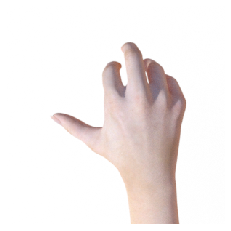

tmp/rps/rock/rock04-048.png


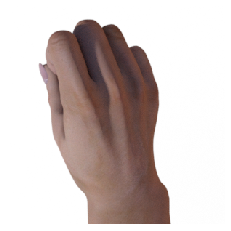

tmp/rps/paper/paper01-014.png


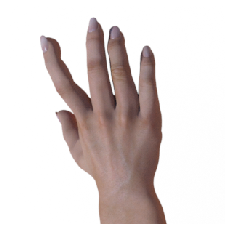

tmp/rps/paper/paper02-030.png


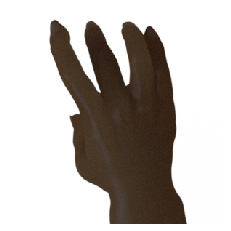

tmp/rps/scissors/testscissors03-083.png


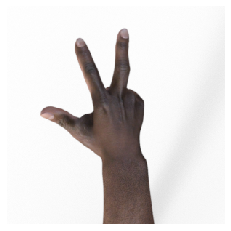

tmp/rps/scissors/scissors03-011.png


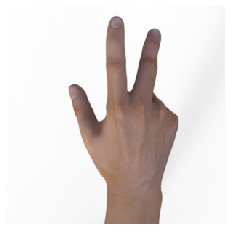

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

##Data pre-process

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


##Make the model

In [6]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________

##Train the model and save it

In [7]:
history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)
model.save("rps.h5")

Epoch 1/25
79/79 [==============================] - 25s 315ms/step - loss: 1.2447 - acc: 0.3877 - val_loss: 0.9361 - val_acc: 0.6022
Epoch 2/25
79/79 [==============================] - 20s 250ms/step - loss: 0.8691 - acc: 0.6032 - val_loss: 0.3553 - val_acc: 0.7984
Epoch 3/25
79/79 [==============================] - 20s 251ms/step - loss: 0.5455 - acc: 0.7802 - val_loss: 0.1570 - val_acc: 0.9758
Epoch 4/25
79/79 [==============================] - 19s 246ms/step - loss: 0.3653 - acc: 0.8627 - val_loss: 0.2443 - val_acc: 0.9382
Epoch 5/25
79/79 [==============================] - 20s 250ms/step - loss: 0.2641 - acc: 0.9040 - val_loss: 0.2557 - val_acc: 0.8656
Epoch 6/25
79/79 [==============================] - 20s 248ms/step - loss: 0.2067 - acc: 0.9226 - val_loss: 0.0372 - val_acc: 1.0000
Epoch 7/25
79/79 [==============================] - 19s 246ms/step - loss: 0.1864 - acc: 0.9282 - val_loss: 0.1563 - val_acc: 0.9651
Epoch 8/25
79/79 [==============================] - 19s 246ms/step - 

##See the training trend

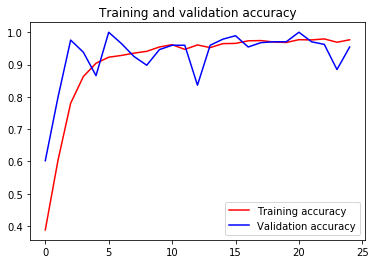

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

##Test the model

In [10]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving testpaper01-01.png to testpaper01-01.png
Saving testrock02-04.png to testrock02-04.png
Saving testscissors02-13.png to testscissors02-13.png
testpaper01-01.png
[[0. 0. 1.]]
testrock02-04.png
[[0. 1. 0.]]
testscissors02-13.png
[[0. 0. 1.]]
